## ICP project for HPPL 


- imports 

In [1]:
%%writefile script.py

from math import *
import numpy as np
import os
from sys import argv
from random import shuffle
from pathlib import Path
import time
import numpy
import numpy as np
from mpi4py import MPI


class Point:
    def __init__(self, s=[], n=[]):
        self.s = s.copy()
        self.n = n.copy()
        self.d = len(s)

    def copy(self):
        newS = self.s.copy()
        newN = self.n.copy()
        newP = Point(newS, newN)
        return newP

    def distTo(self, p):
        return sqrt(self.distSqdTo(p))

    def distSqdTo(self, p):
        distSqd = 0.0
        for i in range(self.d):
            distSqd += (self.s[i] - p.s[i])**2
        return distSqd

    def transform(self, m):
        old = self.s.copy()
        old.append(1.0)
        new = m.dot(old).tolist()[0]
        w = new[-1]
        self.s = [v/w for v in new[:-1]]
        return self


class Box:
    def __init__(self, pMin, pMax):
        self.sMin = pMin.s.copy()
        self.sMax = pMax.s.copy()
        self.d = pMin.d
        for i, (min, max) in enumerate(zip(pMin.s, pMax.s)):
            if (min > max):
                print("Error: Box dimensionality must be positive")
                self.sMin[i] = max
                self.sMax[i] = min

    def copy(self):
        return Box(Point(self.sMin), Point(self.sMax))

    def updateMax(self, val, dim):
        if (val < self.sMin[dim]):
            return
        else:
            self.sMax[dim] = val

    def updateMin(self, val, dim):
        if (val > self.sMax[dim]):
            return
        else:
            self.sMin[dim] = val

    def range(self, dim):
        if (dim < 0 or dim >= self.d):
            return 0

        return self.sMax[dim] - self.sMin[dim]

    def intersects(self, that):
        for min, max in zip(that.sMin, self.sMax):
            if (max < min):
                return False
        for min, max in zip(self.sMin, that.sMax):
            if (max < min):
                return False

        return True

    def contains(self, p):
        for pval, max in zip(p.s, self.sMax):
            if (pval > max):
                return False
        for pval, min in zip(p.s, self.sMin):
            if (pval < min):
                return False
        for min, max in zip(self.sMin, p.sMax):
            if (max < min):
                return False
        return True

    def distTo(self, p):
        return sqrt(self.distSqdTo(p))


    def distSqdTo(self, p):
        distSqd = 0.0
        for pval, min, max in zip(p.s, self.sMin, self.sMax):
            dv = 0.0
            if (pval < min):
                dv = pval - min
            elif (pval > max):
                dv = pval - max
            distSqd += dv*dv

        return distSqd


class Node:

    def __init__(self, p, key, bounds):
        self.key = key

        if (type(p) == Point):
            self.p = p
        else:
            self.p = None
            
        self.bounds = bounds
        if (type(bounds) == Box):
            self.bounds = bounds
        else:
            self.bounds = None

        self.left = None
        self.right = None


class KdTree:
    # Constructor takes int k defining the number of dimensions
    def __init__(self, k=3):
        self.k = k
        self.size = 0
        self.root = None
        self.minP = [-inf for i in range(k)]
        self.maxP = [inf for i in range(k)]

    def insert(self, p):
        bounds = Box(Point(self.minP), Point(self.maxP))
        self.root = self.put(self.root, p, 0, bounds)


    def put(self, node, p, dim, bounds):

        if (node == None):
            self.size += 1
            key = p.s[dim]
            return Node(p, key, bounds)
 
        cmp = p.s[dim] - node.key
        if (cmp < 0):
            upperBounds = bounds.copy()
            upperBounds.updateMax(node.key, dim)
            node.left = self.put(node.left, p, (dim + 1) % self.k, upperBounds)
        else:
            lowerBounds = bounds.copy()
            lowerBounds.updateMin(node.key, dim)
            node.right = self.put(node.right, p, (dim + 1) % self.k, lowerBounds)

        return node

    def nearest(self, p):
        root = self.root
        nearest_p, dist = self.find_nearest(root, p, 0, root.p, p.distSqdTo(root.p))
        return nearest_p

    def find_nearest(self, node, p, dim, candidate, dist):
        if (node == None):
            return candidate, dist

        if (dist < node.bounds.distSqdTo(p)):
            return candidate, dist

        newDist = p.distSqdTo(node.p)
        if (newDist < dist):
            candidate = node.p
            dist = newDist

        go_left = (p.s[dim] < node.key)

        for i in range(2):
            if (go_left):
                candidate, dist = self.find_nearest(node.left, p, (dim + 1) % self.k, candidate, dist)
            else:
                candidate, dist = self.find_nearest(node.right, p, (dim + 1) % self.k, candidate, dist)

            go_left = not go_left

        return candidate, dist
        

def load_xf(file_name):
    with open(file_name) as f:
        data = f.read()
        rows = []
        for r in data.split('\n'):
            if (len(r) > 0):
                rows.append(r)

        if (len(rows) != 4):
            rows = ["0 0 0 0" for i in range(4)]
        result = []
        for r in rows:
            c = []
            for v in r.split(' '):
                if (len(v) > 0):
                    c.append(float(v))
            if (len(c) != 4):
                c = [0, 0, 0, 0]
            result.append(c)
    res = np.matrix(result)
    return res


def load_pts(file_name):
    with open(file_name) as f:
        data = f.read()
        rows = data.split('\n')
        result = []
        for r in rows:
            if (len(r) == 0):
                continue
            pData = [float(v) for v in r.split(' ')]
            if (len(pData) != 6):
                pData = [0, 0, 0, 0, 0, 0]
            result.append(Point(pData[0:3], pData[3:6]))
    return result


def write_xf(file_name, M):
    dir = os.path.dirname(file_name)
    if (not os.path.exists(dir)):
        os.makedirs(dir)

    with open(file_name, "w") as f:
        for row in M.A:
            for val in row:
                f.write(str(val))
                f.write(' ')
            f.write('\n')
    return


def write_pts(file_name, pts):
    dir = os.path.dirname(file_name)
    if (not os.path.exists(dir)):
        os.makedirs(dir)
    with open(file_name, "w") as f:
        for p in pts:
            for val in (p.s + p.n):
                f.write(str(val))
                f.write(' ')
            f.write('\n')
    return


def parallel(pnts, comm, rank, nprocs):
    
    local_inds = numpy.array_split(pnts, nprocs)[rank]
    local_input_values = local_inds

    local_res = [kdtree.nearest(point) for point in local_input_values]
    
    res_list = comm.gather(local_res, root=0)

    if rank == 0:
        res_list = numpy.concatenate(res_list, axis=0)
        return res_list



    
comm = MPI.COMM_WORLD
nprocs = comm.Get_size()
rank = comm.Get_rank()

file1 = Path("./bunny/bun045.pts")
file2 = Path("./bunny/bun000.pts")


pts1 = load_pts(file1)
pts2 = load_pts(file2)


file1_xf = str(file1.with_suffix('')) + '.xf'
file2_xf = str(file2.with_suffix('')) + '.xf'


if (not Path(file1_xf).is_file()):
    M1 = np.identity(4)
else:
    M1 = load_xf(file1_xf)
    
output_file2_xf = './output/' + Path(file2_xf).name + '.xf'

if (not Path(output_file2_xf).is_file()):
    if (not Path(file2_xf).is_file()):
        M2 = np.identity(4)
    else:
        M2 = load_xf(file2_xf)
else:
    M2 = load_xf(output_file2_xf)

kdtree = KdTree()
for p in pts2:
    kdtree.insert(p)
    
time_stat = []
pts_num_range = list(range(1000, 20000, 1000))
main_memory_stat = []

for pts_num in pts_num_range:
    
    print("Num of random points from pointcloud -->", pts_num)
    memory_stat = []

    for _ in range(10):
        
        # ICP iteration (until improvement is less than 0.01%)
        print("Starting iteration...")
        ratio = 0.0
        M2_inverse = M2.I
        pts_index = list(range(len(pts1)))
        print("SIZE -->", len(pts1))
        count = 0
        
        avg_time = 0
    
        start = time.time()
        tracemalloc.start()
        while (ratio < 0.9999):
            shuffle(pts_index)
            # Apply M1 and the inverse of M2
            p = [pts1[i].copy().transform(M1).transform(M2_inverse) for i in pts_index[:pts_num]]
            
            q = parallel(p, comm, rank, nprocs)
            
            if p is  None:
                print("P is None")
            if q is None:
                print("Q is None")
                
            if rank == 0:    

                # Compute point to plane distances
                point2plane = [abs(np.subtract(pi.s, qi.s).dot(qi.n)) for pi,qi in zip(p,q)]
                median_3x = 3.0 * np.median(point2plane)

                # Cull outliers
                point_pairs = []
                dist_sum = 0.0
                for i, pair in enumerate(zip(p,q)):
                    if (point2plane[i] <= median_3x):
                        point_pairs.append(pair)
                        dist_sum += point2plane[i]
                if (len(point_pairs) > 0):
                    old_mean = dist_sum/len(point_pairs)
                else:
                    print("Error: Something went wrong when computing distance means")
                    quit()


                C = np.zeros(shape=(6,6))
                d = np.zeros(shape=(6,1))
                for (p, q) in point_pairs:
                    Ai = np.matrix(np.append(np.cross(p.s, q.n),q.n))
                    AiT = Ai.T
                    bi = np.subtract(q.s, p.s).dot(q.n)

                    C += AiT*Ai
                    d += AiT*bi
                x = np.linalg.solve(C,d).flatten()
                rx,ry,rz,tx,ty,tz = x
                Micp = np.matrix([[1.0, ry*rx - rz, rz*rx + ry, tx],
                                  [rz, 1.0 + rz*ry*rx, rz*ry - rx, ty], 
                                  [-ry, rx, 1.0, tz], 
                                  [0, 0, 0, 1.0]])

                # Compute new mean point-to-plane distance
                dist_sum = 0.0
                for (p, q) in point_pairs:
                    # Apply Micp
                    p = p.transform(Micp)
                    dist_sum += abs(np.subtract(p.s, q.s).dot(q.n))
                new_mean = dist_sum/len(point_pairs)
                count += 1
                ratio = new_mean / old_mean

                # Update M1 iff we improved (otherwise, but NOT only then, we will terminate)
                if (ratio < 1.0):
                    M1 = M2*Micp*M2_inverse*M1
                else:
                    new_mean = old_mean

                print("Finished iteration #{} with improvement of {:2.4%}".format(count, 1.0 - ratio))
            else:
                pass
            memory_stat.append(tracemalloc.get_traced_memory()[1])
        finish = time.time()
        tracemalloc.stop()
        
        
        avg_time += (finish - start)
        main_memory_stat.append(sum(memory_stat) / 10)
        
    time_stat.append(avg_time / 10)
    
    

print("Terminated successfully with a sampled mean distance of {}".format(new_mean))

# Write results to file
output_file1_pts = './output/' + str(file1).split('/')[-1]
output_file1_xf = './output/' + file1_xf.split('/')[-1]
output_file2_pts = './output/' + str(file2).split('/')[-1]
output_file2_xf = './output/' + file2_xf.split('/')[-1]
write_pts(output_file1_pts, pts1)
write_pts(output_file2_pts, pts2)
write_xf(output_file1_xf, M1)
write_xf(output_file2_xf, M2)

print ('Done!!!')

print("For processes: -->", nprocs)
print(pts_num_range)
print(time_stat)

Overwriting script.py


In [ ]:
!mpirun -np 4 python3 ./script.py

Num of random points from pointcloud --> 1000
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of 14.7199%
Finished iteration #2 with improvement of -0.9373%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -2.0616%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -0.3483%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -2.6275%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -1.6613%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of 0.0682%
Finished iteration #2 with improvement of -1.1092%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -2.0551%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -0.6370%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -1.2538%
Starting iteration...
SIZE --> 40011
Finished iteration #1 wi

Finished iteration #1 with improvement of -0.0142%
Num of random points from pointcloud --> 6000
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -0.3238%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of 0.0459%
Finished iteration #2 with improvement of -0.3762%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -0.1022%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -0.3580%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -0.4552%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -0.0962%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -0.1178%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -0.7130%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -0.3824%
Starting iteration...
SIZE --> 40011
Finished iteration #1 wi

Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -0.0574%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -0.0384%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of 0.2045%
Finished iteration #2 with improvement of 0.1205%
Finished iteration #3 with improvement of 0.1015%
Finished iteration #4 with improvement of 0.4796%
Finished iteration #5 with improvement of -0.1681%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -0.0296%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of 0.4031%
Finished iteration #2 with improvement of -0.0742%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of 0.0880%
Finished iteration #2 with improvement of 0.2409%
Finished iteration #3 with improvement of 0.7321%
Finished iteration #4 with improvement of 0.2875%
Finished iteration #5 with improvement of 0.0613%
Finished iteration #6 w

Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -0.2715%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -0.0198%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of 0.0473%
Finished iteration #2 with improvement of 0.2274%
Finished iteration #3 with improvement of 0.4001%
Finished iteration #4 with improvement of -0.2208%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of 0.1638%
Finished iteration #2 with improvement of -0.1524%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of 0.3143%
Finished iteration #2 with improvement of -0.4457%
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of -0.0522%
Num of random points from pointcloud --> 17000
Starting iteration...
SIZE --> 40011
Finished iteration #1 with improvement of 0.1753%
Finished iteration #2 with improvement of 0.1162%
Finished iteration #3 with improvement

[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000]
[0.8092248439788818, 0.10814859867095947, 0.1967165470123291, 0.2181997299194336, 0.2607257604598999, 0.6348996162414551, 0.3790182828903198, 0.41248035430908203, 0.46615478992462156, 0.5140420436859131, 0.5680085182189941, 0.6240926265716553, 0.6709532737731934, 0.7441340208053588, 0.8080725193023681, 0.8285118341445923, 1.0201928853988647, 1.1452388525009156, 1.278507113456726]

[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000]
[0.1496058702468872, 0.45521275997161864, 0.3007772922515869, 0.15357038974761963, 0.17988219261169433, 0.1995532274246216, 0.24731128215789794, 0.3166022777557373, 0.3216017484664917, 0.35647499561309814, 0.35892791748046876, 0.3787637948989868, 0.424187445640564, 0.49089648723602297, 0.47582144737243653, 0.5083916664123536, 0.5232564687728882, 0.5902632474899292, 0.606473708152771]

Text(0, 0.5, 'Time, sec')

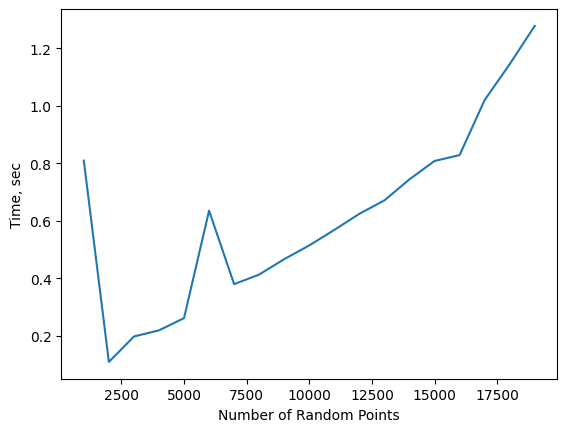

In [14]:
import matplotlib.pyplot as plt

plt.plot(pts_num_range, time_stat)
plt.xlabel('Number of Random Points')
plt.ylabel('Time, sec')